In [1]:
from xmlrpc.client import Error

from dotenv import dotenv_values
from numpy.f2py.auxfuncs import throw_error

print('Jupyter Connected')

Jupyter Connected


In [2]:
!pip install python-dotenv ipywidgets display
!jupyter nbextension enable --py widgetsnbextension

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0 -> 24.2
[notice] To update, run: python3 -m pip install --upgrade pip
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


## Load environment config

In [2]:
import sys


def upload_file(widget, save_path='/opt/spark/conf/.env'):
    # Kiểm tra xem file đã được upload hay chưa
    if widget.value:
        for filename in widget.value:
            print(filename, filename['content'])
            # Lấy nội dung file từ bộ nhớ
            content = filename['content']

            # Đường dẫn lưu file .env trên máy chủ
            # save_path = '/opt/spark/conf/.env'

            # Lưu file .env lên máy chủ
            with open(save_path, 'wb') as f:
                f.write(content)
            # 
            print(f"File .env đã được lưu tại: {save_path}")
            sys.stdout.flush()  # Đẩy dữ liệu ra ngay lập tức

In [27]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [3]:
import ipywidgets as widgets
from IPython.display import display

env_path = '/opt/spark/conf/.env'
# Tạo widget upload file
upload_widget = widgets.FileUpload(multiple=False)

print("Chọn file .env tải lên")
# Hiển thị widget để upload file
display(upload_widget, env_path)


# # Hàm để tự động thực thi khi file được chọn và upload
def on_upload_widget_change(change):
    print('on_upload_widget_change', change, upload_widget.value)
    upload_file(upload_widget)


# Gán hàm "on_upload_change" để theo dõi sự kiện thay đổi giá trị trong widget upload
upload_widget.observe(on_upload_widget_change, names='value')

Chọn file .env tải lên


FileUpload(value=(), description='Upload')

'/opt/spark/conf/.env'

In [4]:
import os
from dotenv import load_dotenv

load_dotenv(env_path)

MINIO_ACCESS_KEY = os.getenv('MINIO_ACCESS_KEY')
MINIO_ACCESS_SECRET = os.getenv('MINIO_ACCESS_SECRET')
MINIO_BUCKET = os.getenv('MINIO_BUCKET')
MINIO_ENDPOINT = os.getenv('MINIO_ENDPOINT_URL')
MINIO_SSL = os.getenv('MINIO_SSL', False)

print(env_path, MINIO_ENDPOINT, MINIO_ACCESS_KEY, MINIO_ACCESS_SECRET)



/opt/spark/conf/.env 103.171.91.207:9000 minioadmin minioadmin


In [5]:

from pyspark.sql import SparkSession
from pyspark.sql.functions import to_timestamp, col
from pyspark.sql.types import StructType, StructField, IntegerType, StringType
from pyspark.sql import Row, Column
from pyspark.sql.functions import lit
from minio import Minio
from delta import *
from torch.utils.data import Dataset
from PIL import Image

In [6]:
# Tạo Spark Session
spark = SparkSession.builder \
    .appName("LabelStudioDataProcessing") \
    .getOrCreate()

24/09/08 06:52:05 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [7]:
sc = spark.sparkContext
# Kết nối với MinIO thông qua Hadoop
# sc._jsc.hadoopConfiguration().set("fs.s3a.endpoint", "http://103.171.91.207:9000")
# sc._jsc.hadoopConfiguration().set("fs.s3a.access.key", "J0AO8J4HEFCVQI2IKJIV")
# sc._jsc.hadoopConfiguration().set("fs.s3a.secret.key", "YBWXmZwkpn+Ifq5wYFNIvxE5Izo8xqPKAC8TIPOgd")
# sc._jsc.hadoopConfiguration().set("fs.s3a.path.style.access", "true")
# sc._jsc.hadoopConfiguration().set("fs.s3a.path.style.access", "true")
# sc._jsc.hadoopConfiguration().set("fs.s3a.connection.ssl.enabled", "false")
# sc._jsc.hadoopConfiguration().set("fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem")
# sc._jsc.hadoopConfiguration().set("fs.s3a.connection.ssl.enabled", "false")
sc._jsc.hadoopConfiguration().set("fs.s3a.access.key", str(MINIO_ACCESS_KEY))
sc._jsc.hadoopConfiguration().set("fs.s3a.secret.key", str(MINIO_ACCESS_SECRET))
sc._jsc.hadoopConfiguration().set("fs.s3a.endpoint", f"http://{MINIO_ENDPOINT}")
sc._jsc.hadoopConfiguration().set("fs.s3a.path.style.access", "true")
sc._jsc.hadoopConfiguration().set("fs.s3a.connection.ssl.enabled", "false")
sc._jsc.hadoopConfiguration().set("fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem")
sc._jsc.hadoopConfiguration().set("fs.s3a.connection.ssl.enabled", str(MINIO_SSL).lower())

In [8]:
# Đọc dữ liệu từ MinIO
def load_json_files(bucket_name, prefix=""):
    # Load tất cả các file từ MinIO mà không cần đuôi .json
    # files = spark.read.json(f"s3a://{bucket_name}")
    df = spark.read.format('json').option('header', 'true').option('inferSchema', 'true').load(
        f"s3a://{bucket_name}")
    return df

In [ ]:
!env

In [9]:
df = spark.read.format('json').load("s3a://datasets/")
df.show()


+--------------------+-----------+--------------------+------------------+--------------------+------------+---+---------+-----------+---------------+---------+-----------------+-----------------+-------+--------------------+--------------------+--------------------+----------+-------------+
|        completed_by|created_ago|          created_at|  created_username|    draft_created_at|ground_truth| id|import_id|last_action|last_created_by|lead_time|parent_annotation|parent_prediction|project|              result|                task|          updated_at|updated_by|was_cancelled|
+--------------------+-----------+--------------------+------------------+--------------------+------------+---+---------+-----------+---------------+---------+-----------------+-----------------+-------+--------------------+--------------------+--------------------+----------+-------------+
|{admin@mail.com, ...|     1 week|2024-08-30T02:07:...| admin@mail.com, 2|2024-08-30T02:06:...|       false|  5|     null

In [ ]:
# Định nghĩa schema với số cột tùy biến
schema = StructType([
    StructField("Column1", IntegerType(), True),
    StructField("Column2", StringType(), True),
    StructField("Column3", IntegerType(), True)
])

# Tạo DataFrame rỗng với schema
empty_df = spark.createDataFrame([], schema)

# Hiển thị DataFrame ban đầu
print("DataFrame ban đầu:")
empty_df.show()

# Thêm dữ liệu mới vào DataFrame
new_data = [
    Row(Column1=1, Column2="Alice", Column3=29),
    Row(Column1=2, Column2="Bob", Column3=35)
]

# Tạo DataFrame với dữ liệu mới
updated_df = spark.createDataFrame(new_data)

# Hiển thị DataFrame với dữ liệu mới
print("DataFrame sau khi thêm dữ liệu:")
updated_df.show()

# Thêm cột mới vào DataFrame và thay đổi vị trí các cột
from pyspark.sql.functions import lit

# Thêm cột mới với giá trị mặc định
updated_df = updated_df.withColumn("NewColumn", lit("Default"))

# Thay đổi vị trí các cột bằng cách chọn lại thứ tự
final_df = updated_df.select("NewColumn", "Column1", "Column2", "Column3")

# Hiển thị DataFrame cuối cùng
print("DataFrame sau khi thêm cột và thay đổi vị trí:")
final_df.show()

## Lấy cấu hình từ Label Studio

In [ ]:
!pip install requests

In [ ]:
!pip install label-studio-sdk

In [23]:
# Import the SDK and the client module
from label_studio_sdk.client import LabelStudio
from label_studio_sdk.label_interface import LabelInterface
from label_studio_sdk.label_interface.objects import PredictionValue

# Define the URL where Label Studio is accessible and the API key for your user account
LABEL_STUDIO_URL = os.getenv('LABEL_STUDIO_URL')
# API key is available at the Account & Settings > Access Tokens page in Label Studio UI
API_KEY = os.getenv('LABEL_STUDIO_API_KEY')
print(LABEL_STUDIO_URL, API_KEY)
# Connect to the Label Studio API and check the connection
ls = LabelStudio(base_url=LABEL_STUDIO_URL, api_key=API_KEY)
projects = ls.projects.list()


http://103.171.91.207:8000 e6a4bc5cb1453a16c494b5ef9abf364c546e4ee5


In [24]:
project = ls.projects.get(id=4)
# LabelInterface provides a handy way to validate Label Studio JSON format for annotations and predictions
print(project.label_config)

<View>
  <!-- Hiển thị hình ảnh sản phẩm -->
  <View style="display:flex;align-items:start;gap:8px;flex-direction:row-reverse"><Image name="image" value="$image" zoom="true" zoomControl="true" rotateControl="true"/><RectangleLabels name="product_attribute" toName="image" choice="single" showInline="false">
    <Label value="product" html="Product" background="blue"/>
    <Label value="attribute" html="Attribute" background="green"/>
    <Label value="meta" html="Meta data" background="yellow"/>
  </RectangleLabels></View>
  
  <!-- Vùng nhãn chính -->
  
  
    <!-- Vùng thông tin chung -->
  <View visibleWhen="region-selected" whenTagName="product_attribute" whenLabelValue="meta">
    <Header value="Config Metadata "/>
    <Header value="Choose meta type" size="8"/>
    <Choices name="meta_choice" toName="image" choice="single" showInLine="true" editable="true" perRegion="true">
      <Choice value="logo" html="Logo" selected="true"/>
      <Choice value="layout" html="Layout"/>
     

### Trích xuất thông tin từ Label config

In [ ]:
!pip install xmljson lxml 

In [25]:
import xml.etree.ElementTree as ET
import xmljson
from json import dumps

# Parse XML of Label config
label_config_xml = ET.fromstring(project.label_config)

# Chuyển đổi XML thành JSON
json_data = xmljson.badgerfish.data(label_config_xml)
print(dumps(json_data))

{"View": {"View": [{"@style": "display:flex;align-items:start;gap:8px;flex-direction:row-reverse", "Image": {"@name": "image", "@value": "$image", "@zoom": true, "@zoomControl": true, "@rotateControl": true}, "RectangleLabels": {"@name": "product_attribute", "@toName": "image", "@choice": "single", "@showInline": false, "Label": [{"@value": "product", "@html": "Product", "@background": "blue"}, {"@value": "attribute", "@html": "Attribute", "@background": "green"}, {"@value": "meta", "@html": "Meta data", "@background": "yellow"}]}}, {"@visibleWhen": "region-selected", "@whenTagName": "product_attribute", "@whenLabelValue": "meta", "Header": [{"@value": "Config Metadata "}, {"@value": "Choose meta type", "@size": 8}], "Choices": {"@name": "meta_choice", "@toName": "image", "@choice": "single", "@showInLine": true, "@editable": true, "@perRegion": true, "Choice": [{"@value": "logo", "@html": "Logo", "@selected": true}, {"@value": "layout", "@html": "Layout"}]}}, {"@visibleWhen": "region-

In [26]:
# Tìm thuộc tính của Attribute
# define Columns name-value
column_name = {"product_id": "Product Id", "product_image": "Product Image", "product_info": "Product Info"}
# Sử dụng XPath để tìm tất cả các thẻ item có name="target"
tag = ".//Choices[@name='attribute_choice']"
attribute_choices_tag = label_config_xml.findall(tag).pop(0) if label_config_xml.findall(tag) else None
# print(attribute_choices_tag,attribute_choices_tag.findall("hoice"))
for choose in attribute_choices_tag.findall("Choice"):
    column_name[choose.attrib.get("value")] = choose.attrib.get("html")


## Tạo DataFrame from Label Studio

### Định nghĩa Data Frame

In [27]:
from pyspark.sql.types import StructType, StructField, IntegerType, StringType

# Định nghĩa schema với số cột tùy biến
schema = StructType(list(map(lambda key: StructField(key, StringType(), True), column_name.keys())))
schema.json()
# Tạo DataFrame rỗng với schema
df = spark.createDataFrame([], schema)

# Hiển thị DataFrame ban đầu
print("DataFrame ban đầu:")
df.show()

DataFrame ban đầu:


+----------+-------------+------------+------------+-----------+-----+--------------+--------+------------+---+--------------+------+----------+----------+------+------+----------+-----+-------+-------+-------+-----+-----------------+
|product_id|product_image|product_info|product_name|description|price|discount_price|category|manufacturer|sku|stock_quantity|status|created_at|updated_at|images|weight|dimensions|brand|barcode|ratings|reviews|solds|custom_attributes|
+----------+-------------+------------+------------+-----------+-----+--------------+--------+------------+---+--------------+------+----------+----------+------+------+----------+-----+-------+-------+-------+-----+-----------------+
+----------+-------------+------------+------------+-----------+-----+--------------+--------+------------+---+--------------+------+----------+----------+------+------+----------+-----+-------+-------+-------+-----+-----------------+



## Tạo data frame từ Minio

In [25]:
from minio import Minio

minio_client = Minio(
    MINIO_ENDPOINT,
    access_key=MINIO_ACCESS_KEY,
    secret_key=MINIO_ACCESS_SECRET,
    secure=MINIO_SSL
)
minio_client.list_buckets()

[Bucket('assets'),
 Bucket('data-files'),
 Bucket('dataframes'),
 Bucket('datasets'),
 Bucket('models'),
 Bucket('results'),
 Bucket('test-bucket')]

### Chuyển Json to Dataframe

In [ ]:
!pip install pydash

In [61]:
import json
import pprint
import copy
from typing import List
from pydash import get, is_empty


class Attribute:
    def __init__(self, id: str):
        self.id = id
        self.type = None  # Tương tự như public type?: string

    def load_type(self, result: List[dict]):
        # Lọc các phần tử với type là "choices" và id khớp với self.id
        choices = list(filter(lambda item: get(item, 'type') == 'choices' and get(item, 'id') == self.id, result))
        if not is_empty(choices):
            self.type = get(choices, '[0].value.choices[0]')

    def __repr__(self):
        return f"Attribute(id='{self.id}', type='{self.type}')"


class Product:
    def __init__(self, id: str):
        self.id = id
        self.attributes = []  # Tương tự như public attributes: Attribute[]

    def load_attributes(self, result: List[dict]):
        # Lọc các phần tử với type là "relation" và id khớp với self.id
        relations = list(filter(lambda item: get(item, 'type') == 'relation' and
                                             self.id in [get(item, 'to_id'), get(item, 'from_id')],
                                result))
        attributes = []
        for item in relations:
            attr_id = get(item, 'from_id') if get(item, 'to_id') == self.id else get(item, 'to_id')
            attribute = Attribute(attr_id)
            attribute.load_type(result)
            attributes.append(attribute)

        self.attributes = copy.deepcopy(attributes)

    def __repr__(self):
        return f"Product(id='{self.id}', attributes={self.attributes})"


In [145]:
from pyspark.sql import Row
import datetime


# Chuyển đổi Product sang đối tượng Row với schema cố định
def convert_product_to_row(product, schema_columns, product_image=None, product_info=None):
    # Tạo một từ điển chỉ thêm các cột có trong schema
    row_data = {col.name: None for col in schema_columns}

    # Kiểm tra giá trị id của product có tồn tại hay không
    row_data['product_id'] = product.id if product.id else None
    row_data['created_at'] = str(datetime.datetime.now())
    row_data['updated_at'] = str(datetime.datetime.now())
    row_data['product_image'] = product_image
    row_data['product_info'] = product_info

    # Kiểm tra attributes có tồn tại và có phải là danh sách không
    if product.attributes and isinstance(product.attributes, list):
        for attribute in product.attributes:
            # Kiểm tra attribute và các thuộc tính con của nó
            if attribute and hasattr(attribute, 'type') and attribute.type:
                # Chuyển attribute.type thành chuỗi nếu cần
                attribute_type_str = str(attribute.type)

                # Gán giá trị id của attribute vào row_data với key là type (phải là chuỗi)
                row_data[attribute_type_str] = attribute.id if hasattr(attribute, 'id') else None

    # Lọc bỏ các khóa không hợp lệ hoặc không phải là chuỗi
    valid_row_data = {key: value for key, value in row_data.items() if isinstance(key, str)}

    # Trả về đối tượng Row với các thuộc tính hợp lệ từ schema
    return Row(**valid_row_data)



In [86]:
def load_product_attributes(data):
    # Lấy giá trị từ data
    result = get(data, 'result', [])

    # Lọc ra các phần tử với type là "rectanglelabels" và label là "product"
    products = list(map(
        lambda item: Product(get(item, 'id', '')),
        filter(
            lambda item: get(item, 'type') == 'rectanglelabels' and get(item, 'value.rectanglelabels[0]') == 'product',
            result)
    ))

    # Tải thuộc tính của mỗi sản phẩm
    for prod in products:
        prod.load_attributes(result)

    return products


In [153]:
import json

datasets_bucket_name = 'datasets'

# Kiểm tra xem bucket có tồn tại hay không
if not minio_client.bucket_exists(datasets_bucket_name):
    raise Exception('Minio bucket does not exist')
data_rows = []
# Lấy đối tượng từ bucket
objects = minio_client.list_objects(bucket_name=datasets_bucket_name, recursive=True)
for obj in objects:
    object = minio_client.get_object(bucket_name=datasets_bucket_name, object_name=obj.object_name)
    print(obj.object_name, object.url)
    # Chuyển Minio object thành json data
    data = json.load(object)
    # print(json.load(object))
    products = load_product_attributes(data)
    # Hiển thị các sản phẩm
    # pprint.pprint(products, depth=5)
    # Lấy thông tin image từ dữ liệu
    product_image = get(data, 'task.data.image')
    # Lấy thông tin info từ dữ liệu
    product_info = object.url
    # Chuyển đổi toàn bộ danh sách Product thành danh sách Row
    products_data_rows = [convert_product_to_row(product, schema_columns=schema,product_image=product_image, product_info=product_info) for product in products]
    # print(products_data_rows)
    data_rows.extend(products_data_rows)
print(data_rows)

5 /datasets/5
6 /datasets/6
[Row(product_id='kH-Y3lvtox', product_image='s3://assets/screencapture-lazada-vn-catalog-2024-08-22-00_52_53.png', product_info='/datasets/5', product_name='zCTsnJjmBo', description=None, price='zFABvA_QCN', discount_price=None, category=None, manufacturer=None, sku=None, stock_quantity=None, status=None, created_at='2024-09-07 09:42:34.725993', updated_at='2024-09-07 09:42:34.726033', images=None, weight=None, dimensions=None, brand=None, barcode=None, ratings=None, reviews=None, solds=None, custom_attributes=None), Row(product_id='RkIjnwqkn2', product_image='s3://assets/screencapture-lazada-vn-catalog-2024-08-22-00_52_53.png', product_info='/datasets/5', product_name='FhUHs0lf-o', description=None, price='FgugZ0wizG', discount_price=None, category=None, manufacturer=None, sku=None, stock_quantity=None, status=None, created_at='2024-09-07 09:42:34.726131', updated_at='2024-09-07 09:42:34.726136', images=None, weight=None, dimensions=None, brand=None, barcod

In [172]:
# Tạo DataFrame từ hàng mới
df_products = spark.createDataFrame(data_rows, schema)
df_products.show(truncate=True)

+----------+--------------------+------------+------------+-----------+----------+--------------+--------+------------+----+--------------+------+--------------------+--------------------+------+------+----------+-----+-------+-------+-------+-----+-----------------+
|product_id|       product_image|product_info|product_name|description|     price|discount_price|category|manufacturer| sku|stock_quantity|status|          created_at|          updated_at|images|weight|dimensions|brand|barcode|ratings|reviews|solds|custom_attributes|
+----------+--------------------+------------+------------+-----------+----------+--------------+--------+------------+----+--------------+------+--------------------+--------------------+------+------+----------+-----+-------+-------+-------+-----+-----------------+
|kH-Y3lvtox|s3://assets/scree...| /datasets/5|  zCTsnJjmBo|       null|zFABvA_QCN|          null|    null|        null|null|          null|  null|2024-09-07 09:42:...|2024-09-07 09:42:...|  null| 

## Lưu DataFrame thành file csv trong Minio

In [177]:
df_products.write.mode('overwrite').option('header', 'true').format('csv').save(f"s3a://dataframes/dataframes_latest.csv",mode='overwrite')
df_products.write.mode('overwrite').option('header', 'true').format('csv').save(f"s3a://dataframes/dataframes_{str(datetime.datetime.now())}.csv",mode='overwrite')

24/09/07 10:04:17 WARN AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.
24/09/07 10:04:18 WARN AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.
24/09/07 10:04:18 WARN AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.


24/09/07 10:04:18 WARN AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.
24/09/07 10:04:19 WARN AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.
24/09/07 10:04:19 WARN AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.


In [179]:
df_read= spark.read.format('csv').option('header', 'true').load("s3a://dataframes/dataframes_latest.csv")
df_read.show(truncate=False)
# print(df_read.schema)

+----------+---------------------------------------------------------------------------------+------------+------------+-----------+----------+--------------+--------+------------+----+--------------+------+--------------------------+--------------------------+------+------+----------+-----+-------+-------+-------+-----+-----------------+
|product_id|product_image                                                                    |product_info|product_name|description|price     |discount_price|category|manufacturer|sku |stock_quantity|status|created_at                |updated_at                |images|weight|dimensions|brand|barcode|ratings|reviews|solds|custom_attributes|
+----------+---------------------------------------------------------------------------------+------------+------------+-----------+----------+--------------+--------+------------+----+--------------+------+--------------------------+--------------------------+------+------+----------+-----+-------+-------+-------+--

In [182]:
df_read.coalesce(1).write.mode('overwrite').option('header', 'true').format('csv').save(f"/tmp/spark/dataframes_latest.csv",mode='overwrite')

## Training Model

### Chuẩn bị dữ liệu

### 1. Đọc và xử lý dữ liệu từ DeltaLake

In [10]:
df_train= spark.read.format('csv').option('header', 'true').load("s3a://dataframes/dataframes_latest.csv")
df_train.show(truncate=False)

+----------+---------------------------------------------------------------------------------+------------+------------+-----------+----------+--------------+--------+------------+----+--------------+------+--------------------------+--------------------------+------+------+----------+-----+-------+-------+-------+-----+-----------------+
|product_id|product_image                                                                    |product_info|product_name|description|price     |discount_price|category|manufacturer|sku |stock_quantity|status|created_at                |updated_at                |images|weight|dimensions|brand|barcode|ratings|reviews|solds|custom_attributes|
+----------+---------------------------------------------------------------------------------+------------+------------+-----------+----------+--------------+--------+------------+----+--------------+------+--------------------------+--------------------------+------+------+----------+-----+-------+-------+-------+--

In [22]:
# Chuyển dữ liệu sang pandas DataFrame để dễ xử lý hơn
pandas_df = df_train.toPandas()

# Kiểm tra cấu trúc dữ liệu
print(pandas_df.head())

   product_id                                      product_image product_info  \
0  RkIjnwqkn2  s3://assets/screencapture-lazada-vn-catalog-20...  /datasets/5   
1  6PPHTtoTAZ  s3://assets/screencapture-cellphones-vn-mobile...  /datasets/6   
2  kH-Y3lvtox  s3://assets/screencapture-lazada-vn-catalog-20...  /datasets/5   

  product_name description       price discount_price category manufacturer  \
0   FhUHs0lf-o        None  FgugZ0wizG           None     None         None   
1         None        None        None           None     None         None   
2   zCTsnJjmBo        None  zFABvA_QCN           None     None         None   

    sku  ...                  updated_at images weight dimensions brand  \
0  None  ...  2024-09-07 09:42:34.726136   None   None       None  None   
1  None  ...  2024-09-07 09:42:34.733842   None   None       None  None   
2  None  ...  2024-09-07 09:42:34.726033   None   None       None  None   

  barcode ratings reviews solds custom_attributes  
0    

### 2. Chuyển đổi dữ liệu JSON thành định dạng Mask R-CNN

In [23]:
import json

def load_annotations(json_file):
    with open(json_file, "r") as f:
        data = json.load(f)
        annotations = []
        for result in data['result']:
            if result['type'] == 'rectanglelabels':
                bbox = result['value']
                annotations.append({
                    "bbox": [bbox['x'], bbox['y'], bbox['x'] + bbox['width'], bbox['y'] + bbox['height']],
                    "label": result['rectanglelabels'][0]
                })
        return annotations

In [41]:
!pip install boto3

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 1.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 6.7 MB/s eta 0:00:0000:0100:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.2/144.2 kB 23.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyterlab-server 2.22.1 requires jsonschema>=4.17.3, but you have jsonschema 3.2.0 which is incompatible.

[notice] A new release of pip is available: 23.0 -> 24.2
[notice] To update, run: python3 -m pip install --upgrade pip


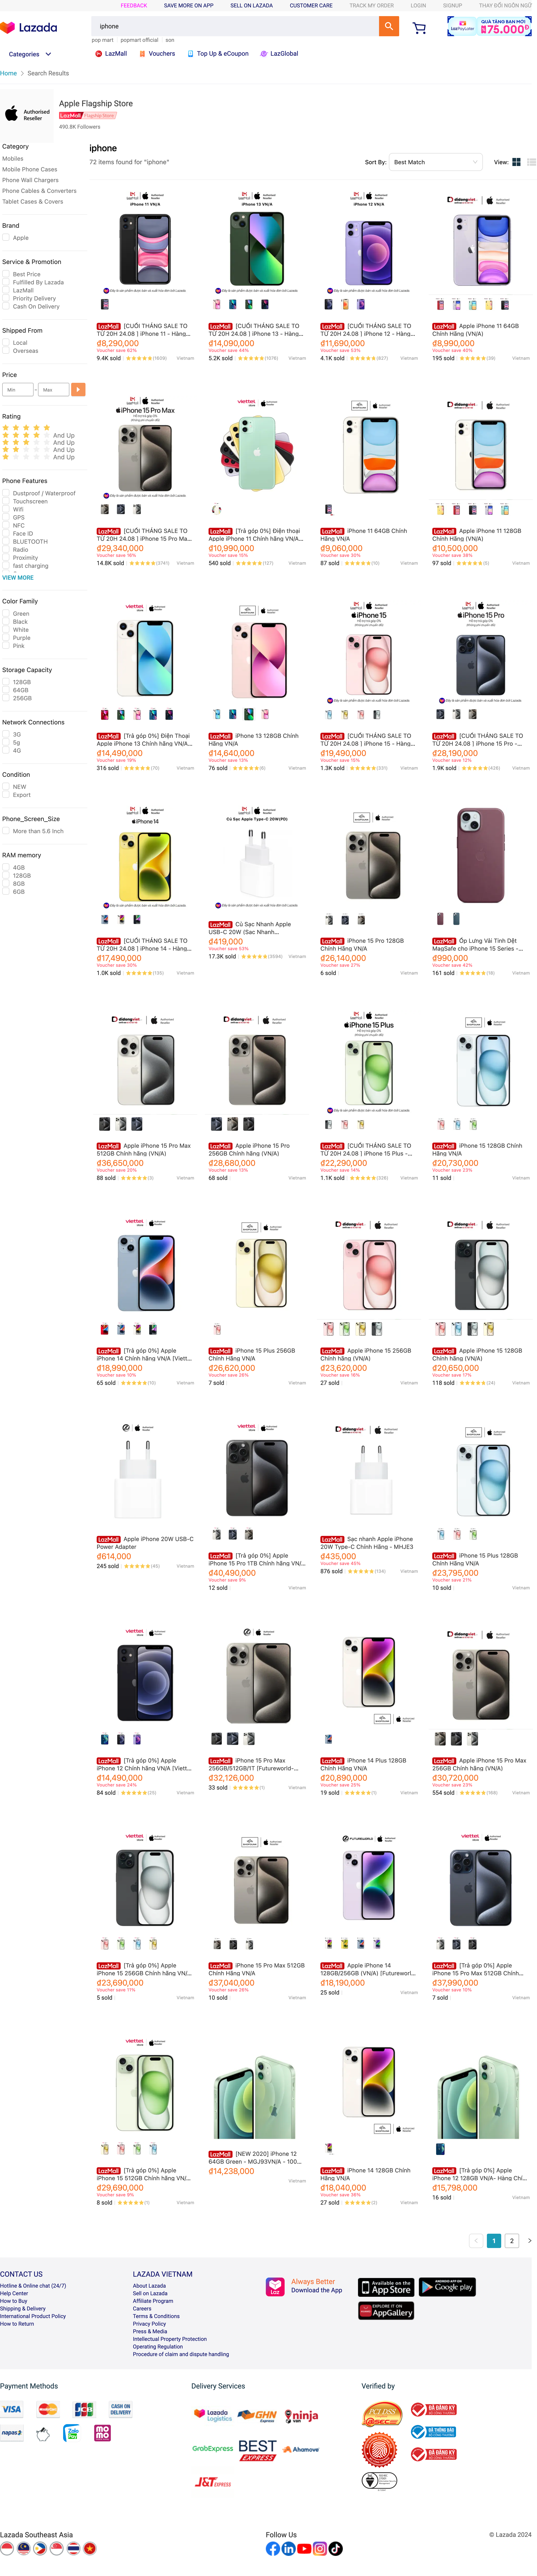

In [43]:
import boto3
from PIL import Image
import io

# Kết nối với Minio hoặc S3
s3_client = boto3.client(
    's3',
    endpoint_url=f"http://{MINIO_ENDPOINT}",  # Địa chỉ Minio của bạn
    aws_access_key_id=str(MINIO_ACCESS_KEY),
    aws_secret_access_key=str(MINIO_ACCESS_SECRET)
)

# Đường dẫn trực tiếp của object (bao gồm cả bucket name và file path)
file_path = "assets/screencapture-lazada-vn-catalog-2024-08-22-00_52_53.png"

# Bucket và file
bucket_name = file_path.split('/')[0]
object_name = '/'.join(file_path.split('/')[1:])

# Tải object
response = s3_client.get_object(Bucket=bucket_name, Key=object_name)
image_data = response['Body'].read()

# Sử dụng Pillow để hiển thị ảnh
image = Image.open(io.BytesIO(image_data))
image.show()

### 3. Tạo Dataset cho PyTorch

In [21]:
import torch
from PIL import Image

class ProductDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, image_dir):
        self.dataframe = dataframe
        self.image_dir = image_dir

    def __getitem__(self, idx):
        image_path = self.dataframe.iloc[idx]['product_image']
        product_info = self.dataframe.iloc[idx]['product_info']

        # Tải hình ảnh
        image = Image.open(image_path).convert("RGB")
        
        # Tải thông tin bounding box từ JSON
        annotations = load_annotations(product_info)

        # Chuyển bounding box thành tensor
        boxes = torch.tensor([anno['bbox'] for anno in annotations], dtype=torch.float32)
        labels = torch.tensor([1 for _ in annotations], dtype=torch.int64)  # Label 1 cho "product"

        target = {"boxes": boxes, "labels": labels}

        return image, target

    def __len__(self):
        return len(self.dataframe)

# Khởi tạo dataset
dataset = ProductDataset(df_train, "/path/to/images/")